In [1]:
import torch
from torchvision import datasets, models, transforms
from torch import nn
import matplotlib.pyplot as plt
from torchinfo import summary
import torchvision

from utils import *
from data_setup import *

/Users/lipeiran/anaconda3/envs/TorchProject/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/lipeiran/anaconda3/envs/TorchProject/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <F0D48035-EF9E-3141-9F63-566920E60D7C> /Users/lipeiran/anaconda3/envs/TorchProject/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <7422C53A-9F13-3592-9338-E2EA7D46A90F> /Users/lipeiran/anaconda3/envs/TorchProject/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")


In [2]:
device = device_check()

train_dir = "./data/pizza_steak_sushi/train"
test_dir = "./data/pizza_steak_sushi/train"

data_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406],
                             std = [0.229, 0.224, 0.225])
        ])

train_dataloader, test_dataloader, classes, class_to_idx = create_dataloaders(train_dir, test_dir,
                                                                data_transform, 32)
device

Using mps device


'mps'

In [3]:
# After torchvision v0.13+, we can directly get the config

# get pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
# then get the transform
trans = weights.transforms()
trans

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [4]:
# OLD version: model = torchvision.models.efficientnet_b0(pretrained = True).to(device)

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

model = torchvision.models.efficientnet_b0(weights).to(device)

print(model)

/Users/lipeiran/anaconda3/envs/TorchProject/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  warnings.warn(


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [5]:
summary(model = model, input_size = (32, 3, 224, 224),
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 15,
        row_settings = ["var_names"]
        )

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224] [32, 1000]      --              True
├─Sequential (features)                                      [32, 3, 224, 224] [32, 1280, 7, 7] --              True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224] [32, 32, 112, 112] --              True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224] [32, 32, 112, 112] 864             True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112] [32, 32, 112, 112] 64              True
│    │    └─SiLU (2)                                         [32, 32, 112, 112] [32, 32, 112, 112] --              --
│    └─Sequential (1)                                        [32, 32, 112, 112] [32, 16, 112, 112] --              True
│    │    └─MBConv (0)                              

In [6]:
for param in model.features.parameters():
    param.requires_grad = False

torch.manual_seed(42)
torch.cuda.manual_seed(42)

ouput_shape = len(classes)

model.classifier = torch.nn.Sequential(
        nn.Dropout(p = 0.2, inplace = True),
        nn.Linear(in_features = 1280, out_features = 3)
        ).to(device)


In [7]:
print(model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [8]:
model = nn.DataParallel(model).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = .001)

from timeit import default_timer as timer
start_time = timer()

results = train(model, train_dataloader, test_dataloader, optimizer, None, loss_fn, 5, device)

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/lipeiran/anaconda3/envs/TorchProject/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/lipeiran/anaconda3/envs/TorchProject/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <F0D48035-EF9E-3141-9F63-566920E60D7C> /Users/lipeiran/anaconda3/envs/TorchProject/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <7422C53A-9F13-3592-9338-E2EA7D46A90F> /Users/lipeiran/anaconda3/envs/TorchProject/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")
/Users/lipeiran/anaconda3/envs/TorchProject/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/lipeiran/anaconda3/env

Epoch: 1 | train_loss: 1.1073 | train_acc: 0.3047 | test_loss: 1.0585 | test_acc: 0.4375


/Users/lipeiran/anaconda3/envs/TorchProject/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/lipeiran/anaconda3/envs/TorchProject/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <F0D48035-EF9E-3141-9F63-566920E60D7C> /Users/lipeiran/anaconda3/envs/TorchProject/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <7422C53A-9F13-3592-9338-E2EA7D46A90F> /Users/lipeiran/anaconda3/envs/TorchProject/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")
/Users/lipeiran/anaconda3/envs/TorchProject/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/lipeiran/anaconda3/env

KeyboardInterrupt: 

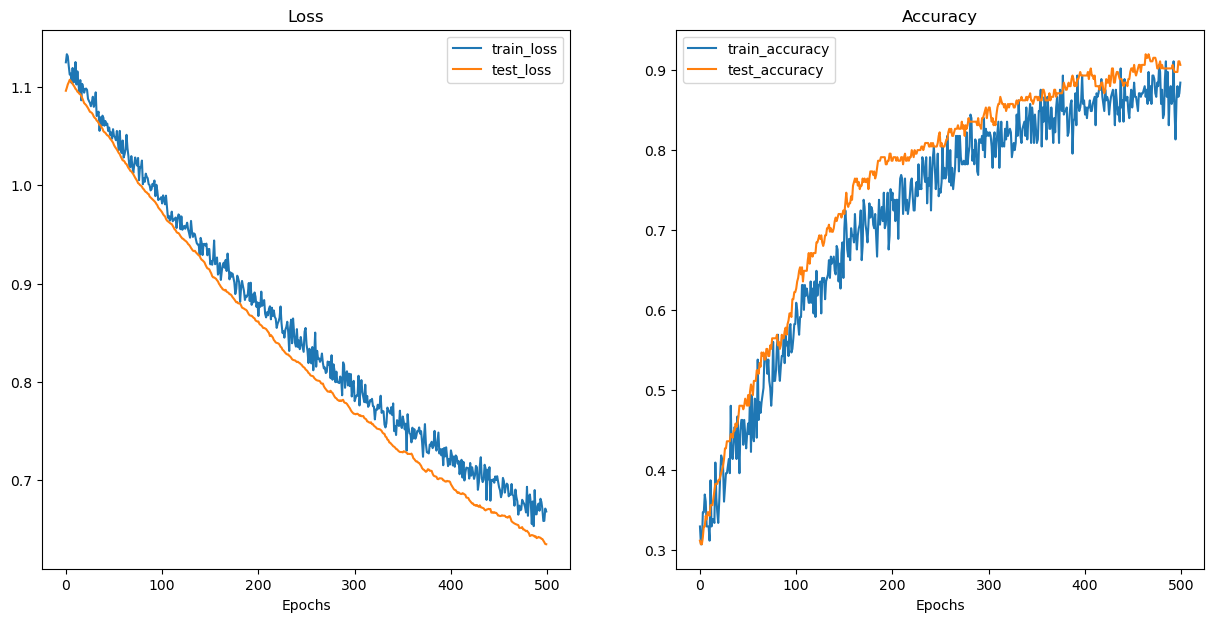